In [2]:
#google
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#import packages
import os
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50

Using TensorFlow backend.


In [0]:
#load dataset
train_path = '/content/gdrive/My Drive/42028-DL-CNN-2020/A2/dataset1/train/' #80
valid_path = '/content/gdrive/My Drive/42028-DL-CNN-2020/A2/dataset1/val/' #10
test_path = '/content/gdrive/My Drive/42028-DL-CNN-2020/A2/dataset1/test/' #10

In [0]:
#ImageGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#datagen flow for multi-class
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224,224),
    class_mode='categorical', batch_size=8)
valid_generator = test_datagen.flow_from_directory(valid_path, target_size=(224,224),
    class_mode='categorical', batch_size=8)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224,224),
    class_mode='categorical', batch_size=8)

Found 900 images belonging to 4 classes.
Found 113 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [7]:
#resnet101
model = ResNet50(weights= 'imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))

94773248/94765736 [==============================] - 3s 0us/step


In [8]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
#adding new layers
x = model.output
x = Flatten()(x)
#add fully connected layer
x = Dense(512,activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512,activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
#add logistic layer
predictions = Dense(4, activation='softmax')(x)
#model to train
model = Model(input=model.input, output=predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
#unfreeze all BatchNormalization layers and freeze all except for last 7 layers
for layer in model.layers[:-7]:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])

In [12]:
#train model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  
      epochs=25,
      validation_data=valid_generator,
      validation_steps=10,  
      verbose=1)

Epoch 1/25
100/100 [==============================] - 332s 3s/step - loss: 1.3007 - acc: 0.5302 - val_loss: 1.3294 - val_acc: 0.3250
Epoch 2/25
100/100 [==============================] - 75s 749ms/step - loss: 0.6978 - acc: 0.7299 - val_loss: 2.9980 - val_acc: 0.2329
Epoch 3/25
100/100 [==============================] - 40s 400ms/step - loss: 0.5578 - acc: 0.7915 - val_loss: 0.0248 - val_acc: 0.2192
Epoch 4/25
100/100 [==============================] - 40s 401ms/step - loss: 0.4947 - acc: 0.8229 - val_loss: 2.9354 - val_acc: 0.2375
Epoch 5/25
100/100 [==============================] - 40s 404ms/step - loss: 0.3728 - acc: 0.8637 - val_loss: 2.7306 - val_acc: 0.2740
Epoch 6/25
100/100 [==============================] - 40s 400ms/step - loss: 0.3950 - acc: 0.8555 - val_loss: 0.7531 - val_acc: 0.3562
Epoch 7/25
100/100 [==============================] - 40s 401ms/step - loss: 0.3739 - acc: 0.8662 - val_loss: 2.0015 - val_acc: 0.4125
Epoch 8/25
100/100 [==============================] - 41s

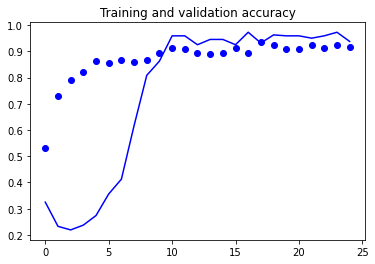

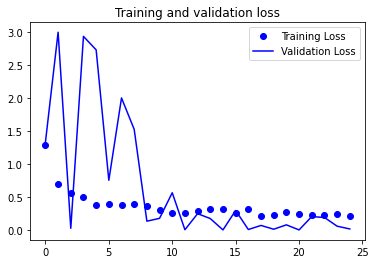

In [13]:
#plot graph
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
test_acc

14/14 [==============================] - 49s 4s/step


0.9553571343421936